In [1]:
%load_ext autoreload

In [9]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
verbose = False
agent_data = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    if agent == 'propofol' and (cfg.params.low_pass is not None or cfg.params.high_pass is not None):
        cfg.params.grid_set = 'grid_set5'
    else:
        cfg.params.grid_set = 'grid_set4'

    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)) if f.endswith('.mat')]
    else:
        session_list = [f[:-4] for f in os.listdir(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
    
    areas = ['all']
    agent_data[(data_class, agent)] = {'session_list': session_list}

    session_lists, locs, rocs, ropaps = get_session_plot_info(cfg, session_list, verbose=False)

    agent_data[(data_class, agent)]['session_lists'] = session_lists
    agent_data[(data_class, agent)]['locs'] = locs
    agent_data[(data_class, agent)]['rocs'] = rocs
    agent_data[(data_class, agent)]['ropaps'] = ropaps

    noise_filter_info = get_noise_filter_info(cfg, session_list, verbose=verbose)
    agent_data[(data_class, agent)]['noise_filter_info'] = noise_filter_info
    
    pca_chosen = get_pca_chosen(cfg, session_list, areas, noise_filter_info, verbose=verbose)
    agent_data[(data_class, agent)]['pca_chosen'] = pca_chosen
    all_indices_to_run = collect_grid_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete grid search - cannot continue")
    
    grid_params_to_use = get_grid_params_to_use(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
    agent_data[(data_class, agent)]['grid_params_to_use'] = grid_params_to_use
    all_indices_to_run = collect_delase_indices_to_run(cfg, session_list, areas, noise_filter_info, pca_chosen, grid_params_to_use, verbose=verbose)
    
    if all_indices_to_run:
        raise ValueError(f"Sessions for agent {agent} have incomplete DeLASE - cannot continue")

    delase_results = get_delase_results(cfg, session_list, areas, grid_params_to_use, pca_chosen, verbose=verbose)
    agent_data[(data_class, agent)]['delase_results'] = delase_results

  0%|          | 0/3 [00:00<?, ?it/s]

Only 0 valid windows could be found for section 'awake lever1' with times [np.float64(-36.23385444444445), np.float64(-26.050830555555557)]
Only 3 valid windows could be found for section 'early unconscious' with times [np.float64(26.003301111111107), 45]
Only 1 valid windows could be found for section 'awake lever1' with times [np.float64(-36.120676111111116), np.float64(-26.045618333333337)]
Only 3 valid windows could be found for section 'awake lever1' with times [np.float64(-36.10079944444445), np.float64(-26.03974944444445)]
Only 0 valid windows could be found for section 'awake lever2' with times [np.float64(-10.029036111111115), 0]


In [7]:
area = 'all'
# save_dir = "/orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/power_analysis"
save_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/power_analysis"

In [13]:
top_percent = 0.1
doses = ['high']

power_info = {}
corr_power_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    delase_results = agent_data[(data_class, agent)]['delase_results']
    cfg.params.data_class = data_class
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    power_info[(data_class, agent)] = {}
    corr_power_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        power_info[(data_class, agent)][monkey] = {}
        corr_power_info[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            power_info[(data_class, agent)][monkey][dose] = {}
            corr_power_info[(data_class, agent)][monkey][dose] = {}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                    # raise ValueError(f"Session {session} does not exist")
                    print(f"Session {session} does not exist, skipping")
                else:
                    ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
                    freq_powers = ret_dict['freq_powers']
                    # corr_power_info[(data_class, agent)][monkey][dose][session] = {band: pearsonr(delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()), freq_powers[band]).statistic for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
                    corr_power_info[(data_class, agent)][monkey][dose][session] = {band: spearmanr(delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()), freq_powers[band]).statistic for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
                    freq_r2_scores = ret_dict['freq_r2_scores']
                    power_info[(data_class, agent)][monkey][dose][session] = freq_r2_scores


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
plot_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    plot_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        plot_info[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            plot_info[(data_class, agent)][monkey][dose] = {band: [] for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
            # for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
            for session in corr_power_info[(data_class, agent)][monkey][dose]:
                for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
                    # plot_info[(data_class, agent)][monkey][dose][band].append(power_info[(data_class, agent)][monkey][dose][session][band])
                    plot_info[(data_class, agent)][monkey][dose][band].append(corr_power_info[(data_class, agent)][monkey][dose][session][band])

  0%|          | 0/3 [00:00<?, ?it/s]

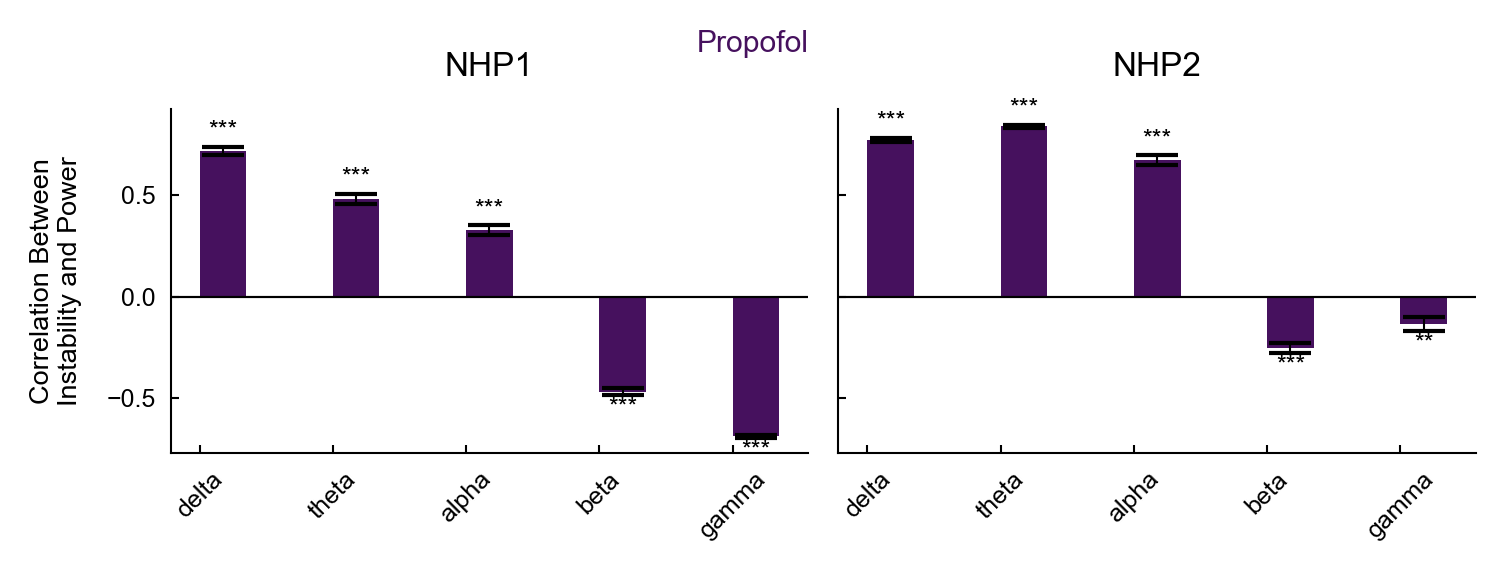

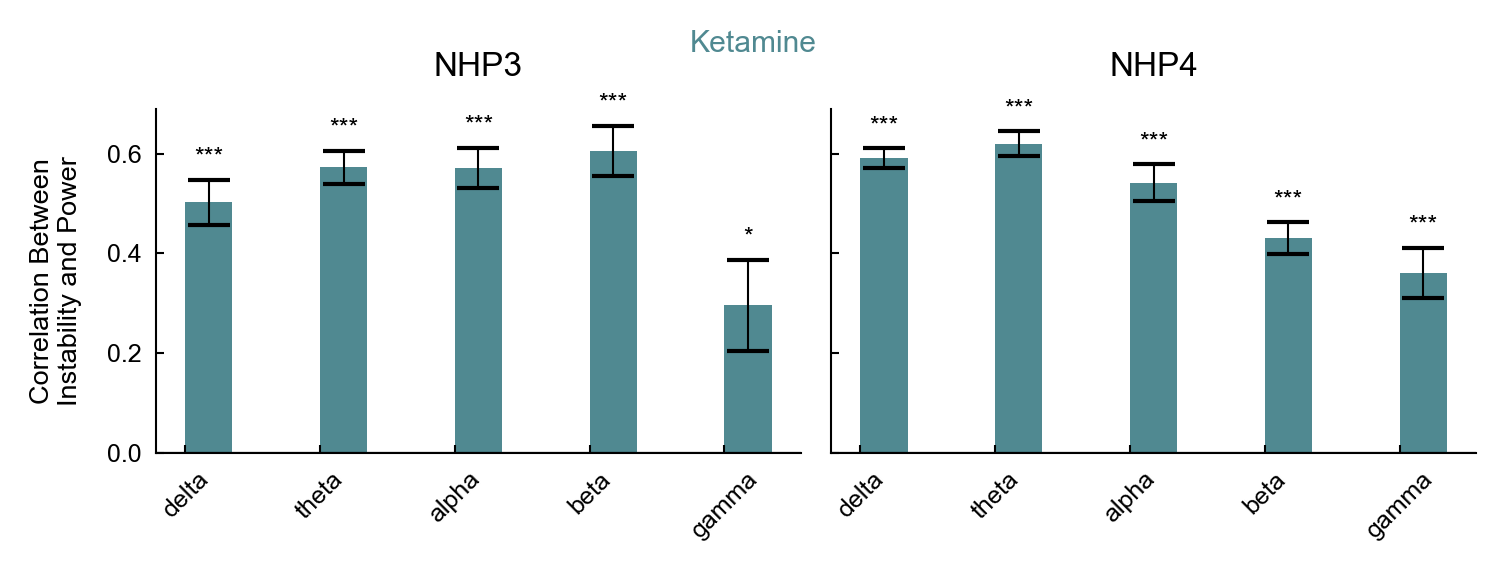

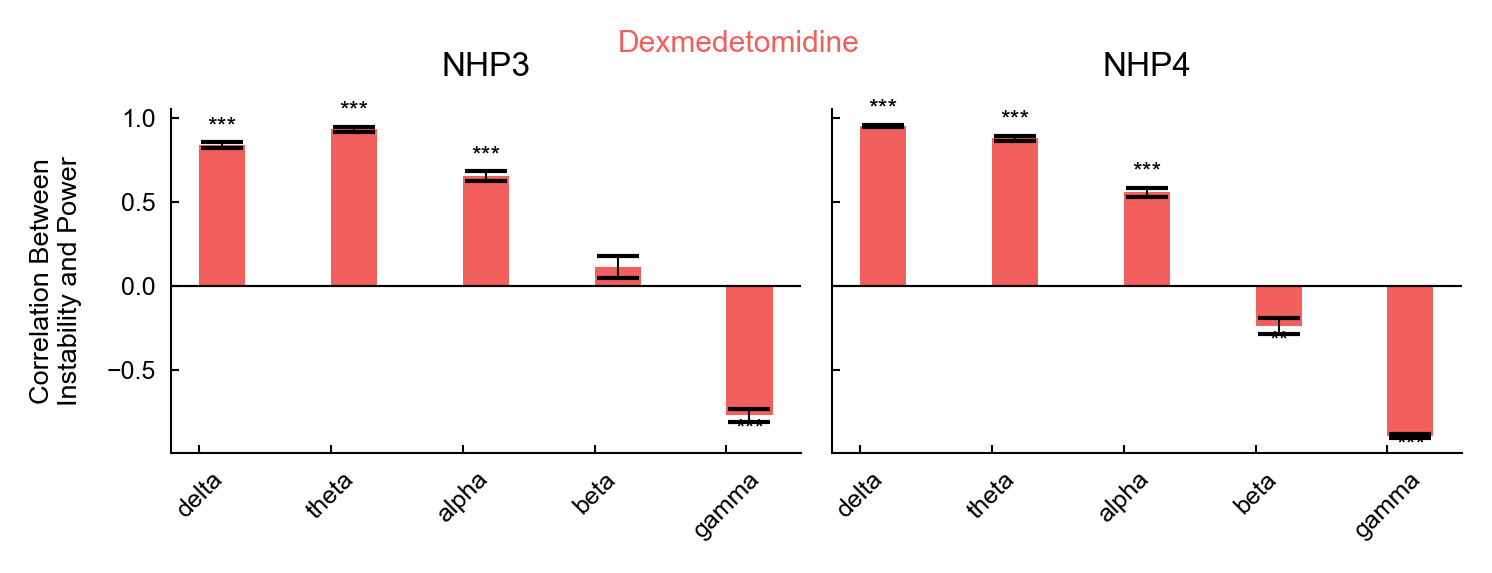

In [15]:

for data_class, agent in anesthetic_agent_list:
    plot_power_analysis(plot_info, data_class, agent, curve_colors, save_path=os.path.join(img_save_dir, f'{agent}_power_analysis.png'))

In [88]:
data_class, agent = anesthetic_agent_list[1]
monkey = 'PEDRI'
dose = 'high'
session = 'PEDRI_Ketamine_20220209'

agent_save_dir = os.path.join(save_dir, data_class, agent, area)
ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
freq_powers = ret_dict['freq_powers']


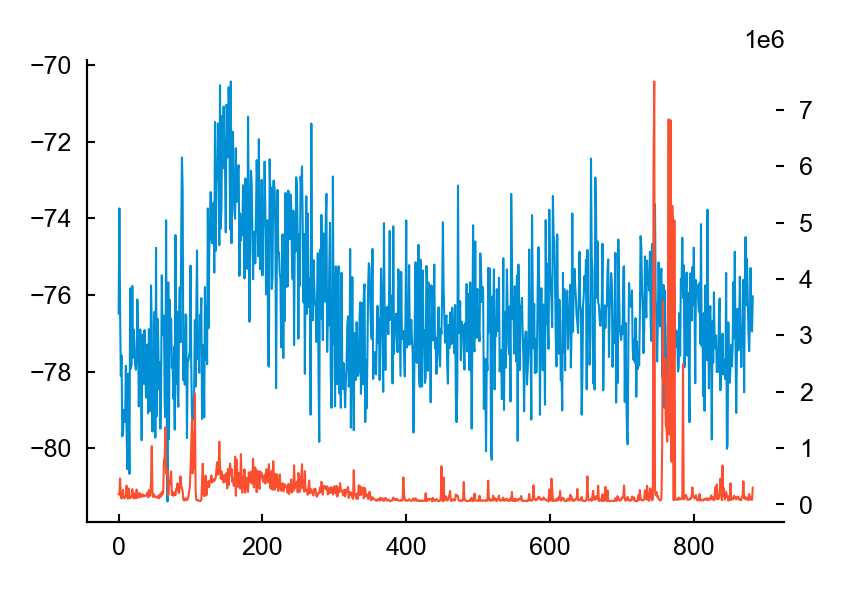

In [89]:
plt.plot(agent_data[(data_class, agent)]['delase_results'][session][area].stability_params.apply(lambda x: x[int(top_percent*len(x))]))
ax2 = plt.gca().twinx()
ax2.plot(freq_powers['delta'], c='C1')

In [74]:
corr_power_info[(data_class, agent)][monkey][dose]

{'PEDRI_Ketamine_20220209': {'delta': np.float64(0.041367184465890515),
  'theta': np.float64(-0.009870643176993538),
  'alpha': np.float64(-0.02160958178440921),
  'beta': np.float64(-0.032029790931976776),
  'gamma': np.float64(0.14318713016736886)},
 'PEDRI_Ketamine_20220106': {'delta': np.float64(0.07773318814457661),
  'theta': np.float64(0.07689548710789762),
  'alpha': np.float64(0.015728502290277346),
  'beta': np.float64(0.005148788949854082),
  'gamma': np.float64(0.22300874967137188)},
 'PEDRI_Ketamine_20220201': {'delta': np.float64(0.349323254034113),
  'theta': np.float64(0.4929308735392606),
  'alpha': np.float64(0.4129453089262336),
  'beta': np.float64(0.1850857118961707),
  'gamma': np.float64(0.5633768232681539)},
 'PEDRI_Ketamine_20220111': {'delta': np.float64(-6.002826097287542e-05),
  'theta': np.float64(0.0674755955028803),
  'alpha': np.float64(-0.020685137169409187),
  'beta': np.float64(-0.03994240627052112),
  'gamma': np.float64(0.2486751662593916)},
 'PEDR

In [ ]:
#TODO: NOTE, turn weird things into strengths! the fact that it doesn't correlate well is a strength!
# Delta is inconsistent, and can't be relied on to determine unconsciousness
# however instability IS consistent across monkeys/sessions